In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                                      mean   
epochs AL.epochs ratio dataset AL.iter bs  lr      ProbVLM PL         metric             method              
5      5.0       0.1   RSICD   5.0     32  0.00005 True    None       image_to_text_R@1  base     3.756667   
                                                                      image_to_text_R@10 base    24.966667   
                                                                      image_to_text_R@5  base    15.140000   
                                                                      text_to_image_R@1  base     3.693333   
                                                                      text_to_image_R@10 base    24.206667   
...                                                                                                    ...   
35     NaN       0.1   UCM-CLS NaN     128 0.00050 False   hard.text  zeroshot-val-top1  ours     4.808889   
                                                           ot.image   zeroshot-val-top1  ours     5.906667   
                                                           ot.text    zeroshot-val-top1  ours    19.002222   
                                                           soft.image zeroshot-val-top1  ours    11.246667   
                                                           soft.text  zeroshot-val-top1  ours     4.808889   

                                                                                                           \
                                                                                                      std   
epochs AL.epochs ratio dataset AL.iter bs  lr      ProbVLM PL         metric             method             
5      5.0       0.1   RSICD   5.0     32  0.00005 True    None       image_to_text_R@1  base    0.641431   
                                                                      image_to_text_R@10 base    0.870479   
                                                                      image_to_text_R@5  base    0.697209   
                                                                      text_to_image_R@1  base    0.142945   
                                                                      text_to_image_R@10 base    1.577857   
...                                                                                                   ...   
35     NaN       0.1   UCM-CLS NaN     128 0.00050 False   hard.text  zeroshot-val-top1  ours    0.281800   
                                                           ot.image   zeroshot-val-top1  ours    2.690938   
                                                           ot.text    zeroshot-val-top1  ours    1.723940   
                                                           soft.image zeroshot-val-top1  ours    4.526925   
                                                           soft.text  zeroshot-val-top1  ours    0.187979   

                                                                                                       
                                                                                                count  
epochs AL.epochs ratio dataset AL.iter bs  lr      ProbVLM PL         metric             method        
5      5.0       0.1   RSICD   5.0     32  0.00005 True    None       image_to_text_R@1  base       3  
                                                                      image_to_text_R@10 base       3  
                                                                      image_to_text_R@5  base       3  
                                                                      text_to_image_R@1  base       3  
                                                                      text_to_image_R@10 base       3  
...                                                                                               ...  
35     NaN       0.1   UCM-CLS NaN     128 0.00050 False   hard.text  zeroshot-val-top1  ours    

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

epochs AL.epochs ratio  dataset AL.iter   bs       lr ProbVLM         PL  \
                                                                                
366       5       5.0   0.1    RSICD     NaN   64  0.00050   False  soft.text   
6480     30      30.0   0.1    RSICD     NaN   64  0.00050   False  soft.text   
348       5       5.0   0.1    RSICD     NaN   64  0.00050   False   ot.image   
7422     35      35.0   0.1    RSICD     NaN  128  0.00050   False  hard.text   
474       5       5.0   0.1    RSICD     NaN  128  0.00050   False   ot.image   
...     ...       ...   ...      ...     ...  ...      ...     ...        ...   
1139      5       5.0   0.5  UCM-CLS     NaN   64  0.00005   False       None   
4019     15      15.0   0.7  UCM-CLS     NaN   64  0.00005   False       None   
1159      5       5.0   0.7  UCM-CLS     NaN   64  0.00005   False       None   
3999     15      15.0   0.5  UCM-CLS     NaN   64  0.00005   False       None   
2439     10      10.0   0.7  UCM-CLS     NaN   64  0.00005   False       None   

                 metric method    value                  
                                   mean       std count  
366   image_to_text_R@1   ours   0.0675  0.045000     4  
6480  image_to_text_R@1   ours   0.0675  0.045000     4  
348   image_to_text_R@1   ours   0.0700  0.060000     9  
7422  image_to_text_R@1   ours   0.0700  0.039686     9  
474   image_to_text_R@1   ours   0.0800  0.030000     9  
...                 ...    ...      ...       ...   ...  
1139  zeroshot-val-top1   base  77.7550  3.436680     4  
4019  zeroshot-val-top1   base  77.9725  3.209884     4  
1159  zeroshot-val-top1   base  78.1875  5.256433     4  
3999  zeroshot-val-top1   base  78.2875  3.939225     4  
2439  zeroshot-val-top1   base  78.3975  3.115032     4  

[8040 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

epochs AL.epochs ratio    dataset AL.iter  bs       lr ProbVLM    PL  \
                                                                            
5192     25       5.0   0.1      RSICD    20.0  32  0.00005    True  None   
1400     10      20.0   0.1      RSICD     5.0  32  0.00005    True  None   
5240     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
2633     15      10.0   0.1     Sydney     5.0  32  0.00005    True  None   
5207     25       5.0   0.1     Sydney    10.0  32  0.00005    True  None   
5387     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5417     25      20.0   0.1        UCM    20.0  32  0.00005    True  None   
5305     25      10.0   0.1        UCM     5.0  32  0.00005    True  None   
5405     25      20.0   0.1        UCM     5.0  32  0.00005    True  None   
2561     15      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
2441     15       5.0   0.1      RSICD     5.0  32  0.00005    True  None   
5241     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
2858     15      20.0   0.1     Sydney    10.0  32  0.00005    True  None   
5376     25      20.0   0.1     Sydney     5.0  32  0.00005    True  None   
5388     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5312     25      10.0   0.1        UCM    10.0  32  0.00005    True  None   
1251     10       5.0   0.1        UCM    10.0  32  0.00005    True  None   
1239     10       5.0   0.1        UCM     5.0  32  0.00005    True  None   
5188     25       5.0   0.1      RSICD    10.0  32  0.00005    True  None   
2466     15       5.0   0.1      RSICD    20.0  32  0.00005    True  None   
5242     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
5383     25      20.0   0.1     Sydney    10.0  32  0.00005    True  None   
5389     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5377     25      20.0   0.1     Sydney     5.0  32  0.00005    True  None   
5419     25      20.0   0.1        UCM    20.0  32  0.00005    True  None   
5313     25      10.0   0.1        UCM    10.0  32  0.00005    True  None   
5407     25      20.0   0.1        UCM     5.0  32  0.00005    True  None   
2605     15      10.0   0.1      RSICD    20.0  32  0.00005    True  None   
2443     15       5.0   0.1      RSICD     5.0  32  0.00005    True  None   
5243     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
5284     25      10.0   0.1     Sydney    10.0  32  0.00005    True  None   
5390     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5378     25      20.0   0.1     Sydney     5.0  32  0.00005    True  None   
2902     15      20.0   0.1        UCM     5.0  32  0.00005    True  None   
5228     25       5.0   0.1        UCM    10.0  32  0.00005    True  None   
5222     25       5.0   0.1        UCM     5.0  32  0.00005    True  None   
5344     25      20.0   0.1      RSICD     5.0  32  0.00005    True  None   
1164     10       5.0   0.1      RSICD     5.0  32  0.00005    True  None   
5244     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
5279     25      10.0   0.1     Sydney     5.0  32  0.00005    True  None   
5391     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5379     25      20.0   0.1     Sydney     5.0  32  0.00005    True  None   
5223     25       5.0   0.1        UCM     5.0  32  0.00005    True  None   
5315     25      10.0   0.1        UCM    10.0  32  0.00005    True  None   
5409     25      20.0   0.1        UCM     5.0  32  0.00005    True  None   
5197     25       5.0   0.1      RSICD    20.0  32  0.00005    True  None   
2607     15      10.0   0.1      RSICD    20.0  32  0.00005    True  None   
5245     25      10.0   0.1      RSICD     5.0  32  0.00005    True  None   
5212     25       5.0   0.1     Sydney    10.0  32  0.00005    True  None   
5392     25      20.0   0.1     Sydney    20.0  32  0.00005    True  None   
5

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

epochs AL.epochs ratio    dataset AL.iter  bs       lr ProbVLM    PL  \
                                                                            
4026     20       5.0   0.1      RSICD    10.0  64  0.00005   False  None   
4080     20      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
4086     20      10.0   0.1      RSICD    10.0  64  0.00005   False  None   
5299     25      10.0   0.1     Sydney    30.0  64  0.00005   False  None   
5399     25      20.0   0.1     Sydney    30.0  64  0.00005   False  None   
4200     20      20.0   0.1     Sydney    20.0  64  0.00005   False  None   
4218     20      20.0   0.1        UCM    10.0  64  0.00005   False  None   
4065     20       5.0   0.1        UCM    10.0  64  0.00005   False  None   
4212     20      20.0   0.1        UCM     5.0  64  0.00005   False  None   
1287     10      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
4027     20       5.0   0.1      RSICD    10.0  64  0.00005   False  None   
4081     20      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
4109     20      10.0   0.1     Sydney     5.0  64  0.00005   False  None   
5400     25      20.0   0.1     Sydney    30.0  64  0.00005   False  None   
4201     20      20.0   0.1     Sydney    20.0  64  0.00005   False  None   
1389     10      10.0   0.1        UCM    20.0  64  0.00005   False  None   
2948     15      20.0   0.1        UCM    20.0  64  0.00005   False  None   
4066     20       5.0   0.1        UCM    10.0  64  0.00005   False  None   
4162     20      20.0   0.1      RSICD     5.0  64  0.00005   False  None   
4088     20      10.0   0.1      RSICD    10.0  64  0.00005   False  None   
4082     20      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
4208     20      20.0   0.1     Sydney    30.0  64  0.00005   False  None   
5401     25      20.0   0.1     Sydney    30.0  64  0.00005   False  None   
4202     20      20.0   0.1     Sydney    20.0  64  0.00005   False  None   
1390     10      10.0   0.1        UCM    20.0  64  0.00005   False  None   
2949     15      20.0   0.1        UCM    20.0  64  0.00005   False  None   
4067     20       5.0   0.1        UCM    10.0  64  0.00005   False  None   
5261     25      10.0   0.1      RSICD    20.0  64  0.00005   False  None   
5367     25      20.0   0.1      RSICD    30.0  64  0.00005   False  None   
4181     20      20.0   0.1      RSICD    30.0  64  0.00005   False  None   
4111     20      10.0   0.1     Sydney     5.0  64  0.00005   False  None   
4203     20      20.0   0.1     Sydney    20.0  64  0.00005   False  None   
5402     25      20.0   0.1     Sydney    30.0  64  0.00005   False  None   
4233     20      20.0   0.1        UCM    30.0  64  0.00005   False  None   
4221     20      20.0   0.1        UCM    10.0  64  0.00005   False  None   
5432     25      20.0   0.1        UCM    30.0  64  0.00005   False  None   
4090     20      10.0   0.1      RSICD    10.0  64  0.00005   False  None   
4030     20       5.0   0.1      RSICD    10.0  64  0.00005   False  None   
4084     20      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
5303     25      10.0   0.1     Sydney    30.0  64  0.00005   False  None   
4198     20      20.0   0.1     Sydney    10.0  64  0.00005   False  None   
4204     20      20.0   0.1     Sydney    20.0  64  0.00005   False  None   
5433     25      20.0   0.1        UCM    30.0  64  0.00005   False  None   
2763     15      10.0   0.1        UCM    30.0  64  0.00005   False  None   
2951     15      20.0   0.1        UCM    20.0  64  0.00005   False  None   
4031     20       5.0   0.1      RSICD    10.0  64  0.00005   False  None   
2783     15      20.0   0.1      RSICD     5.0  64  0.00005   False  None   
4085     20      10.0   0.1      RSICD     5.0  64  0.00005   False  None   
5304     25      10.0   0.1     Sydney    30.0  64  0.00005   False  None   
4131     20      10.0   0.1     Sydney    30.0  64  0.00005   False  None   
4

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

epochs AL.epochs ratio    dataset AL.iter   bs       lr ProbVLM    PL  \
                                                                             
5562     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
7242     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
6402     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
6696     30      30.0   0.1     Sydney     NaN   64  0.00005   False  None   
6822     30      30.0   0.1     Sydney     NaN  128  0.00005   False  None   
7662     35      35.0   0.1     Sydney     NaN  128  0.00005   False  None   
7788     35      35.0   0.1        UCM     NaN   64  0.00005   False  None   
6234     25      25.0   0.1        UCM     NaN  128  0.00005   False  None   
6948     30      30.0   0.1        UCM     NaN   64  0.00005   False  None   
6403     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
5563     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
7243     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
6823     30      30.0   0.1     Sydney     NaN  128  0.00005   False  None   
6697     30      30.0   0.1     Sydney     NaN   64  0.00005   False  None   
7537     35      35.0   0.1     Sydney     NaN   64  0.00005   False  None   
7789     35      35.0   0.1        UCM     NaN   64  0.00005   False  None   
7915     35      35.0   0.1        UCM     NaN  128  0.00005   False  None   
7075     30      30.0   0.1        UCM     NaN  128  0.00005   False  None   
5564     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
6404     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
7244     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
6698     30      30.0   0.1     Sydney     NaN   64  0.00005   False  None   
6824     30      30.0   0.1     Sydney     NaN  128  0.00005   False  None   
7664     35      35.0   0.1     Sydney     NaN  128  0.00005   False  None   
7916     35      35.0   0.1        UCM     NaN  128  0.00005   False  None   
7790     35      35.0   0.1        UCM     NaN   64  0.00005   False  None   
7076     30      30.0   0.1        UCM     NaN  128  0.00005   False  None   
5565     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
6405     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
7245     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
5985     25      25.0   0.1     Sydney     NaN  128  0.00005   False  None   
6825     30      30.0   0.1     Sydney     NaN  128  0.00005   False  None   
7665     35      35.0   0.1     Sydney     NaN  128  0.00005   False  None   
6951     30      30.0   0.1        UCM     NaN   64  0.00005   False  None   
7077     30      30.0   0.1        UCM     NaN  128  0.00005   False  None   
7917     35      35.0   0.1        UCM     NaN  128  0.00005   False  None   
5566     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
7246     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
6406     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
7666     35      35.0   0.1     Sydney     NaN  128  0.00005   False  None   
7540     35      35.0   0.1     Sydney     NaN   64  0.00005   False  None   
6700     30      30.0   0.1     Sydney     NaN   64  0.00005   False  None   
7918     35      35.0   0.1        UCM     NaN  128  0.00005   False  None   
6952     30      30.0   0.1        UCM     NaN   64  0.00005   False  None   
7792     35      35.0   0.1        UCM     NaN   64  0.00005   False  None   
5567     25      25.0   0.1      RSICD     NaN   64  0.00005   False  None   
7247     35      35.0   0.1      RSICD     NaN   64  0.00005   False  None   
6407     30      30.0   0.1      RSICD     NaN   64  0.00005   False  None   
6827     30      30.0   0.1     Sydney     NaN  128  0.00005   False  None   
7541     35      35.0   0.1

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

epochs AL.epochs ratio    dataset AL.iter   bs       lr ProbVLM  \
                                                                       
5706     25      25.0   0.1      RSICD     NaN  128  0.00005   False   
6546     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
7386     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
3593     15      15.0   0.1     Sydney     NaN  128  0.00005   False   
6840     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7680     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6252     25      25.0   0.1        UCM     NaN  128  0.00005   False   
7092     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7932     35      35.0   0.1        UCM     NaN  128  0.00005   False   
5707     25      25.0   0.1      RSICD     NaN  128  0.00005   False   
7387     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6547     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
6001     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
6841     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7681     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7807     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7093     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7933     35      35.0   0.1        UCM     NaN  128  0.00005   False   
5708     25      25.0   0.1      RSICD     NaN  128  0.00005   False   
6548     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
7388     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6716     30      30.0   0.1     Sydney     NaN   64  0.00005   False   
6842     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7682     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7934     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7094     30      30.0   0.1        UCM     NaN  128  0.00005   False   
6254     25      25.0   0.1        UCM     NaN  128  0.00005   False   
6549     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
7389     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
7263     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
7683     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6843     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
6003     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
6255     25      25.0   0.1        UCM     NaN  128  0.00005   False   
7095     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7935     35      35.0   0.1        UCM     NaN  128  0.00005   False   
5710     25      25.0   0.1      RSICD     NaN  128  0.00005   False   
6550     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
7390     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6004     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
6844     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7684     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7096     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7810     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7936     35      35.0   0.1        UCM     NaN  128  0.00005   False   
5711     25      25.0   0.1      RSICD     NaN  128  0.00005   False   
7391     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6551     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
6005     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
6845     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7685     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6257     25      25.0   0.1        UCM     NaN  128  0.00005   False   
7097     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7937     35      35.0   0.1        UCM     Na

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

epochs AL.epochs ratio    dataset AL.iter   bs       lr ProbVLM  \
                                                                       
6438     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
6558     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
7278     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
6852     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7572     35      35.0   0.1     Sydney     NaN   64  0.00005   False   
7692     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7110     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7824     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7950     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7405     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
7279     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
6439     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
5893     25      25.0   0.1     Sydney     NaN   64  0.00005   False   
6859     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7699     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6265     25      25.0   0.1        UCM     NaN  128  0.00005   False   
7825     35      35.0   0.1        UCM     NaN   64  0.00005   False   
6985     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7406     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6440     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7280     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
7694     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6860     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7700     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7112     30      30.0   0.1        UCM     NaN  128  0.00005   False   
6986     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7826     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7407     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6441     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
6567     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
6021     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
6855     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7701     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6267     25      25.0   0.1        UCM     NaN  128  0.00005   False   
7827     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7947     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7408     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6442     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7282     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
6862     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7696     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7702     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6148     25      25.0   0.1        UCM     NaN   64  0.00005   False   
6988     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7828     35      35.0   0.1        UCM     NaN   64  0.00005   False   
6569     30      30.0   0.1      RSICD     NaN  128  0.00005   False   
6443     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7283     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
6863     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
6857     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7697     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7829     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7955     35      35.0   0.1        UCM     NaN  128  0.00005   False   
6989     30      30.0   0.1        UCM     Na

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

epochs AL.epochs ratio    dataset AL.iter   bs       lr ProbVLM  \
                                                                       
5574     25      25.0   0.1      RSICD     NaN   64  0.00005   False   
7380     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
7254     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
7542     35      35.0   0.1     Sydney     NaN   64  0.00005   False   
6702     30      30.0   0.1     Sydney     NaN   64  0.00005   False   
5868     25      25.0   0.1     Sydney     NaN   64  0.00005   False   
6954     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7086     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7926     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7381     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6415     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7255     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
7675     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6709     30      30.0   0.1     Sydney     NaN   64  0.00005   False   
7549     35      35.0   0.1     Sydney     NaN   64  0.00005   False   
6955     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7801     35      35.0   0.1        UCM     NaN   64  0.00005   False   
6961     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7256     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
5576     25      25.0   0.1      RSICD     NaN   64  0.00005   False   
6416     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
6710     30      30.0   0.1     Sydney     NaN   64  0.00005   False   
7676     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
5870     25      25.0   0.1     Sydney     NaN   64  0.00005   False   
7928     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7796     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7088     30      30.0   0.1        UCM     NaN  128  0.00005   False   
5577     25      25.0   0.1      RSICD     NaN   64  0.00005   False   
6417     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7257     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
5997     25      25.0   0.1     Sydney     NaN  128  0.00005   False   
7677     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6837     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
6963     30      30.0   0.1        UCM     NaN   64  0.00005   False   
7929     35      35.0   0.1        UCM     NaN  128  0.00005   False   
7797     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7384     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6418     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7258     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
6712     30      30.0   0.1     Sydney     NaN   64  0.00005   False   
6838     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7678     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
6964     30      30.0   0.1        UCM     NaN   64  0.00005   False   
6124     25      25.0   0.1        UCM     NaN   64  0.00005   False   
7804     35      35.0   0.1        UCM     NaN   64  0.00005   False   
7385     35      35.0   0.1      RSICD     NaN  128  0.00005   False   
6419     30      30.0   0.1      RSICD     NaN   64  0.00005   False   
7259     35      35.0   0.1      RSICD     NaN   64  0.00005   False   
5873     25      25.0   0.1     Sydney     NaN   64  0.00005   False   
6839     30      30.0   0.1     Sydney     NaN  128  0.00005   False   
7679     35      35.0   0.1     Sydney     NaN  128  0.00005   False   
7091     30      30.0   0.1        UCM     NaN  128  0.00005   False   
7805     35      35.0   0.1        UCM     NaN   64  0.00005   False   
6965     30      30.0   0.1        UCM     Na

# Test split evaluation results

In [12]:
test_path = './test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 76230
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
76225,ILT,image_to_text_R@5,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76226,ILT,image_to_text_R@10,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76227,ILT,text_to_image_R@1,60.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76228,ILT,text_to_image_R@5,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
76225,ILT,image_to_text_R@5,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76226,ILT,image_to_text_R@10,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76227,ILT,text_to_image_R@1,60.00,0.10,base,False,NaN,NaN,None,25,0.00005,32
76228,ILT,text_to_image_R@5,100.00,0.10,base,False,NaN,NaN,None,25,0.00005,32


value  \
                                                                                            mean   
epochs AL.epochs ratio dataset  AL.iter bs lr      ProbVLM PL   metric             method          
0      NaN       0.0   AID      NaN     64 0.00005 False   None zeroshot-val-top1  base    52.82   
                       RESISC45 NaN     64 0.00005 False   None zeroshot-val-top1  base    48.71   
                       RSICD    NaN     64 0.00005 False   None image_to_text_R@1  base     3.48   
                                                                image_to_text_R@10 base    20.59   
                                                                image_to_text_R@5  base    12.53   
...                                                                                          ...   
35     NaN       0.4   UCM      NaN     64 0.00005 False   None text_to_image_R@1  base    13.33   
                                                                text_to_image_R@10 base    83.81   
                                                                text_to_image_R@5  base    50.00   
                       UCM-CLS  NaN     64 0.00005 False   None zeroshot-val-top1  base    73.81   
                       WHU-RS19 NaN     64 0.00005 False   None zeroshot-val-top1  base    93.53   

                                                                                                \
                                                                                           std   
epochs AL.epochs ratio dataset  AL.iter bs lr      ProbVLM PL   metric             method        
0      NaN       0.0   AID      NaN     64 0.00005 False   None zeroshot-val-top1  base    0.0   
                       RESISC45 NaN     64 0.00005 False   None zeroshot-val-top1  base    0.0   
                       RSICD    NaN     64 0.00005 False   None image_to_text_R@1  base    0.0   
                                                                image_to_text_R@10 base    0.0   
                                                                image_to_text_R@5  base    0.0   
...                                                                                        ...   
35     NaN       0.4   UCM      NaN     64 0.00005 False   None text_to_image_R@1  base    NaN   
                                                                text_to_image_R@10 base    NaN   
                                                                text_to_image_R@5  base    NaN   
                       UCM-CLS  NaN     64 0.00005 False   None zeroshot-val-top1  base    NaN   
                       WHU-RS19 NaN     64 0.00005 False   None zeroshot-val-top1  base    NaN   

                                                                                                 
                                                                                          count  
epochs AL.epochs ratio dataset  AL.iter bs lr      ProbVLM PL   metric             method        
0      NaN       0.0   AID      NaN     64 0.00005 False   None zeroshot-val-top1  base       2  
                       RESISC45 NaN     64 0.00005 False   None zeroshot-val-top1  base       2  
                       RSICD    NaN     64 0.00005 False   None image_to_text_R@1  base       2  
                                                                image_to_text_R@10 base       2  
                                                                image_to_text_R@5  base       2  
...                                                                                         ...  
35     NaN       0.4   UCM      NaN     64 0.00005 False   None text_to_image_R@1  base       1  
                                                                text_to_image_R@10 base       1  
                                                                text_to_image_R@5  base       1  
                       UCM-CLS  NaN     64 0.00005 False   None zeroshot-val-top1  base       1  
                       WHU-RS19 NaN     64 

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

epochs AL.epochs ratio   dataset AL.iter   bs       lr ProbVLM  \
                                                                       
27         1       1.0  0.05       ILT     NaN   32  0.00005   False   
106        1       1.0  0.10       ILT     NaN   32  0.00005   False   
473        2       2.0  0.05       ILT     NaN   32  0.00005   False   
552        2       2.0  0.10       ILT     NaN   32  0.00005   False   
919        3       3.0  0.05       ILT     NaN   32  0.00005   False   
...      ...       ...   ...       ...     ...  ...      ...     ...   
10217     22      22.0  0.80  WHU-RS19     NaN   64  0.00005   False   
5941      13      13.0  0.80  WHU-RS19     NaN  128  0.00005   False   
10663     23      23.0  0.80  WHU-RS19     NaN   64  0.00005   False   
9327      20      20.0  0.80  WHU-RS19     NaN  128  0.00005   False   
8689      19      19.0  0.80  WHU-RS19     NaN  128  0.00005   False   

              PL             metric method   value                  
                                              mean       std count  
27          None  image_to_text_R@1   base  60.000  0.000000     5  
106         None  image_to_text_R@1   base  60.000       NaN     1  
473         None  image_to_text_R@1   base  60.000  0.000000     5  
552         None  image_to_text_R@1   base  60.000       NaN     1  
919         None  image_to_text_R@1   base  60.000  0.000000     5  
...          ...                ...    ...     ...       ...   ...  
10217  hard.text  zeroshot-val-top1   ours  97.172  0.979398     5  
5941    ot.image  zeroshot-val-top1   ours  97.272  0.308577     5  
10663  hard.text  zeroshot-val-top1   ours  97.352  1.024119     5  
9327    ot.image  zeroshot-val-top1   ours  97.372  0.308577     5  
8689    ot.image  zeroshot-val-top1   ours  97.532  0.621627     5  

[12542 rows x 14 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
# display(df_no_finetune)

In [16]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

epochs AL.epochs ratio    dataset AL.iter  bs       lr ProbVLM    PL  \
                                                                             
11247     25      25.0  0.05      RSICD     NaN  64  0.00005   False  None   
11350     25      25.0  0.10      RSICD     NaN  64  0.00005   False  None   
11446     25      25.0  0.20      RSICD     NaN  64  0.00005   False  None   
11542     25      25.0  0.40      RSICD     NaN  64  0.00005   False  None   
11728     25      25.0  1.00      RSICD     NaN  64  0.00005   False  None   
11638     25      25.0  0.80      RSICD     NaN  64  0.00005   False  None   
11279     25      25.0  0.05     Sydney     NaN  64  0.00005   False  None   
11382     25      25.0  0.10     Sydney     NaN  64  0.00005   False  None   
11478     25      25.0  0.20     Sydney     NaN  64  0.00005   False  None   
11574     25      25.0  0.40     Sydney     NaN  64  0.00005   False  None   
11670     25      25.0  0.80     Sydney     NaN  64  0.00005   False  None   
11736     25      25.0  1.00     Sydney     NaN  64  0.00005   False  None   
11303     25      25.0  0.05        UCM     NaN  64  0.00005   False  None   
11406     25      25.0  0.10        UCM     NaN  64  0.00005   False  None   
11502     25      25.0  0.20        UCM     NaN  64  0.00005   False  None   
11598     25      25.0  0.40        UCM     NaN  64  0.00005   False  None   
11694     25      25.0  0.80        UCM     NaN  64  0.00005   False  None   
11742     25      25.0  1.00        UCM     NaN  64  0.00005   False  None   
11248     25      25.0  0.05      RSICD     NaN  64  0.00005   False  None   
11351     25      25.0  0.10      RSICD     NaN  64  0.00005   False  None   
11447     25      25.0  0.20      RSICD     NaN  64  0.00005   False  None   
11543     25      25.0  0.40      RSICD     NaN  64  0.00005   False  None   
11639     25      25.0  0.80      RSICD     NaN  64  0.00005   False  None   
11729     25      25.0  1.00      RSICD     NaN  64  0.00005   False  None   
11280     25      25.0  0.05     Sydney     NaN  64  0.00005   False  None   
11383     25      25.0  0.10     Sydney     NaN  64  0.00005   False  None   
11479     25      25.0  0.20     Sydney     NaN  64  0.00005   False  None   
11575     25      25.0  0.40     Sydney     NaN  64  0.00005   False  None   
11671     25      25.0  0.80     Sydney     NaN  64  0.00005   False  None   
11737     25      25.0  1.00     Sydney     NaN  64  0.00005   False  None   
11304     25      25.0  0.05        UCM     NaN  64  0.00005   False  None   
11407     25      25.0  0.10        UCM     NaN  64  0.00005   False  None   
11503     25      25.0  0.20        UCM     NaN  64  0.00005   False  None   
11599     25      25.0  0.40        UCM     NaN  64  0.00005   False  None   
11695     25      25.0  0.80        UCM     NaN  64  0.00005   False  None   
11743     25      25.0  1.00        UCM     NaN  64  0.00005   False  None   
11249     25      25.0  0.05      RSICD     NaN  64  0.00005   False  None   
11352     25      25.0  0.10      RSICD     NaN  64  0.00005   False  None   
11448     25      25.0  0.20      RSICD     NaN  64  0.00005   False  None   
11544     25      25.0  0.40      RSICD     NaN  64  0.00005   False  None   
11640     25      25.0  0.80      RSICD     NaN  64  0.00005   False  None   
11730     25      25.0  1.00      RSICD     NaN  64  0.00005   False  None   
11281     25      25.0  0.05     Sydney     NaN  64  0.00005   False  None   
11384     25      25.0  0.10     Sydney     NaN  64  0.00005   False  None   
11480     25      25.0  0.20     Sydney     NaN  64  0.00005   False  None   
11576     25      25.0  0.40     Sydney     NaN  64  0.00005   False  None   
11738     25      25.0  1.00     Sydney     NaN  64  0.00005   False  None   
11672     25      25.0  0.80     Sydney     NaN  64  0.00005   False  None   
11305     25      25.0  0.05        UCM     NaN  64  0.00005   False  None   
11408     25      25.0  0.10

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [20]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [10], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  'probvlm': [10]} # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                performance = np.pad(performance, ((1,1)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((1,1)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 RSICD


epochs AL.epochs ratio dataset AL.iter  bs       lr ProbVLM    PL  \
                                                                          
4          0       0.0  0.00   RSICD     NaN  64  0.00005   False  None   
11249     25      25.0  0.05   RSICD     NaN  64  0.00005   False  None   
11352     25      25.0  0.10   RSICD     NaN  64  0.00005   False  None   
11448     25      25.0  0.20   RSICD     NaN  64  0.00005   False  None   
11544     25      25.0  0.40   RSICD     NaN  64  0.00005   False  None   
11640     25      25.0  0.80   RSICD     NaN  64  0.00005   False  None   
11730     25      25.0  1.00   RSICD     NaN  64  0.00005   False  None   

                  metric method   value                  
                                   mean       std count  
4      image_to_text_R@5   base  12.530  0.000000     2  
11249  image_to_text_R@5   base  12.992  0.965023     5  
11352  image_to_text_R@5   base  17.108  0.715730     5  
11448  image_to_text_R@5   base  21.264  0.627120     5  
11544  image_to_text_R@5   base  25.308  0.668296     5  
11640  image_to_text_R@5   base  28.928  0.533170     5  
11730  image_to_text_R@5   base  30.450  1.038821     5

s-clip image_to_text_R@5 RSICD


epochs AL.epochs ratio dataset AL.iter   bs       lr ProbVLM        PL  \
                                                                               
11267     25      25.0  0.05   RSICD     NaN  128  0.00005   False  ot.image   
11370     25      25.0  0.10   RSICD     NaN  128  0.00005   False  ot.image   
11466     25      25.0  0.20   RSICD     NaN  128  0.00005   False  ot.image   
11562     25      25.0  0.40   RSICD     NaN  128  0.00005   False  ot.image   
11658     25      25.0  0.80   RSICD     NaN  128  0.00005   False  ot.image   

                  metric method   value                  
                                   mean       std count  
11267  image_to_text_R@5   ours  14.054  0.175442     5  
11370  image_to_text_R@5   ours  17.288  0.406964     5  
11466  image_to_text_R@5   ours  20.422  0.652932     5  
11562  image_to_text_R@5   ours  24.502  0.160997     5  
11658  image_to_text_R@5   ours  28.890  0.355246     5

soft-pl image_to_text_R@5 RSICD


epochs AL.epochs ratio dataset AL.iter  bs       lr ProbVLM         PL  \
                                                                               
12242     30      30.0  0.05   RSICD     NaN  64  0.00005   False  soft.text   
12290     30      30.0  0.10   RSICD     NaN  64  0.00005   False  soft.text   
12338     30      30.0  0.20   RSICD     NaN  64  0.00005   False  soft.text   
12386     30      30.0  0.40   RSICD     NaN  64  0.00005   False  soft.text   
12426     30      30.0  0.80   RSICD     NaN  64  0.00005   False  soft.text   

                  metric method   value                  
                                   mean       std count  
12242  image_to_text_R@5   ours  14.548  1.289484     5  
12290  image_to_text_R@5   ours  17.456  0.516169     5  
12338  image_to_text_R@5   ours  21.864  1.338462     5  
12386  image_to_text_R@5   ours  23.918  0.636137     5  
12426  image_to_text_R@5   ours  28.966  0.631847     5

hard-pl image_to_text_R@5 RSICD


epochs AL.epochs ratio dataset AL.iter  bs       lr ProbVLM         PL  \
                                                                               
11255     25      25.0  0.05   RSICD     NaN  64  0.00005   False  hard.text   
11358     25      25.0  0.10   RSICD     NaN  64  0.00005   False  hard.text   
11454     25      25.0  0.20   RSICD     NaN  64  0.00005   False  hard.text   
11550     25      25.0  0.40   RSICD     NaN  64  0.00005   False  hard.text   
11646     25      25.0  0.80   RSICD     NaN  64  0.00005   False  hard.text   

                  metric method   value                  
                                   mean       std count  
11255  image_to_text_R@5   ours  13.706  1.082603     5  
11358  image_to_text_R@5   ours  17.310  0.658141     5  
11454  image_to_text_R@5   ours  20.018  0.399274     5  
11550  image_to_text_R@5   ours  25.546  1.126202     5  
11646  image_to_text_R@5   ours  29.712  0.040249     5

basic-al image_to_text_R@5 RSICD


Empty DataFrame
Columns: [(epochs, ), (AL.epochs, ), (ratio, ), (dataset, ), (AL.iter, ), (bs, ), (lr, ), (ProbVLM, ), (PL, ), (metric, ), (method, ), (value, mean), (value, std), (value, count)]
Index: []

ValueError: x and y must have same first dimension, but have shapes (7,) and (2,)

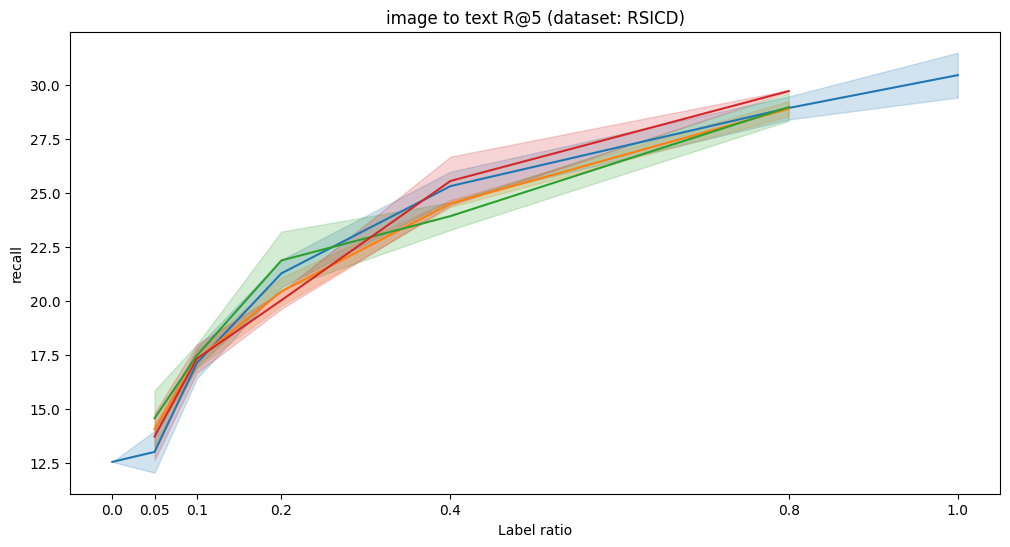

In [21]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

In [ ]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

In [ ]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)

In [ ]:
metric = 'text_to_image_R@5'
datasets = ['ILT']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)